
Running learning curve...

Train size: 10%	R^2 on test: -0.919
Train size: 20%	R^2 on test: -0.379
Train size: 30%	R^2 on test: -0.104
Train size: 40%	R^2 on test: 0.015
Train size: 50%	R^2 on test: 0.014
Train size: 60%	R^2 on test: 0.077
Train size: 70%	R^2 on test: 0.111
Train size: 80%	R^2 on test: 0.113
Train size: 90%	R^2 on test: 0.134
Train size: 100%	R^2 on test: 0.157


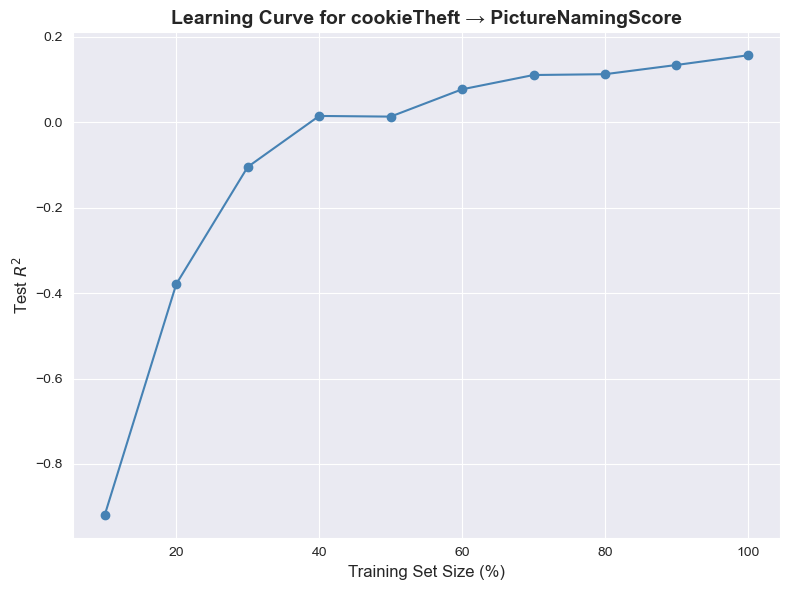


Saved learning curve data to:
/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/plots/learning_curves/learning_curve_cookieTheft_PictureNamingScore.csv
Saved plot to:
/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/plots/learning_curves/learning_curve_plot_cookieTheft_PictureNamingScore.png


In [7]:
# determine optimal training size for model -> I'd say 80%
# decide: train/test split or train/validate/test split?
# -> do further reading, because maybe 80-10-10 is too small... either: 80-20 or 80-10-10

# setup
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")
from config.constants import GIT_DIRECTORY

# inputs
task_name = "cookieTheft"
target = "SemanticFluencyScore"

# path to feature and score files
features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered.csv")
scores_path = os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv")

# load and merge
features = pd.read_csv(features_path)
scores = pd.read_csv(scores_path)
df = pd.merge(features, scores[["Subject_ID", target]], on="Subject_ID").dropna()

# define X and y
X = df.drop(columns=["Subject_ID", target])
y = df[target]

# standardize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# fixed test set -> use 20%
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# explore training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

r2_scores = []

print("\nRunning learning curve...\n")
for frac in train_sizes:
    if frac >= 1.0:
        # can't subsample 100% using train_test_split, just use full data
        X_sub = X_trainval
        y_sub = y_trainval
    else:
        X_sub, _, y_sub, _ = train_test_split(X_trainval, y_trainval, train_size=frac, random_state=42)

    model = LinearRegression()
    model.fit(X_sub, y_sub)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    print(f"Train size: {int(frac * 100)}%\tR^2 on test: {r2:.3f}")

# plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * 100, r2_scores, marker="o", linestyle="-", color="steelblue")
plt.title(f"Learning Curve for {task_name} → {target}", fontsize=14, fontweight="bold")
plt.xlabel("Training Set Size (%)", fontsize=12)
plt.ylabel("Test $R^2$", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# save results
learning_curve_df = pd.DataFrame({
    "TrainingSize%": (train_sizes * 100).astype(int),
    "Test_R2": r2_scores
})

# output folder
output_dir = os.path.join(GIT_DIRECTORY, "results", "plots", "learning_curves")
os.makedirs(output_dir, exist_ok=True)

# save CSV
output_csv = os.path.join(output_dir, f"learning_curve_{task_name}_{target}.csv")
learning_curve_df.to_csv(output_csv, index=False)
print(f"\nSaved learning curve data to:\n{output_csv}")

# save plot
output_plot = os.path.join(output_dir, f"learning_curve_plot_{task_name}_{target}.png")
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * 100, r2_scores, marker="o", linestyle="-", color="steelblue")
plt.title(f"Learning Curve for {task_name} → {target}", fontsize=14, fontweight="bold")
plt.xlabel("Training Set Size (%)", fontsize=12)
plt.ylabel("Test $R^2$", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(output_plot, dpi=300)
plt.close()
print(f"Saved plot to:\n{output_plot}")
